# Importing packages 

In [1]:
filename = r'CNN-LSTM_All_Features'
depth = r'0mm'
location = r'ChunCheon'
model = r'CNN-LSTM'
trained_on = 'All'

In [2]:
from datetime import datetime
now = datetime.now()
date_time_string = str(now.year) + str(now.month).zfill(2) + str(now.day).zfill(2) + "_" + str(now.hour).zfill(2) + str(now.minute).zfill(2) + str(now.second).zfill(2)
date_processed = date_time_string

In [3]:
model_folder = r'C:\Users\w10\Desktop\TRR\Final Codes\LSTM\ChunCheon\Model'
results_folder = r'C:\Users\w10\Desktop\TRR\Final Codes\LSTM\ChunCheon\Results'

In [5]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import numpy as np
import random as rn
from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Activation, BatchNormalization
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
import random as python_random

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

print('Libraries Loaded')

Libraries Loaded


# Custom functions

In [6]:
def create_dataset(X, y, time_steps, ts_range):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    assert (0. <= ts <= 1)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train)
    scaler_single.fit(train[output])
    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])
    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)
    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)
    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

In [7]:
src = r'C:\Users\w10\Desktop\TRR\Final Codes\Data'
csv_filename = r'ChunCheon.csv'
dataframe = pandas.read_csv(os.path.join(src,csv_filename), engine='python').fillna(0)
dataset = dataframe.values
dest = results_folder

In [8]:
look_back = 6
n_ahead = 1
train_share = 0.8
all_training_features = ['Air_Temperature', 'LPF_1', 'LPF_2', 'LPF_3', 
                         'Rainfall', 'Wind_Speed', 'Humidity','Solar_Radiation', 'Snow', 
                         '0mm']
x_features = ['Air_Temperature', 'LPF_1', 'LPF_2', 'LPF_3',
              'Rainfall', 'Wind_Speed', 'Humidity','Solar_Radiation', 'Snow']
y_features = ['0mm']

## Creating the matrices for training

In [9]:
x_train,x_test,y_train,y_test,scaler = splitter(dataframe[all_training_features],['0mm'],look_back,n_ahead,train_share)

In [10]:
epochs = 200
batch_size = 64
lr = 0.001
n_layer = 32
val_split = 0.2

if look_back ==1:
    ker_size = 1
else:
    ker_size = 3

In [12]:
cnnlstm = keras.Sequential()
cnnlstm.add(keras.layers.Conv1D(n_layer, kernel_size=ker_size, input_shape=(x_train .shape[1],x_train .shape[2])))
cnnlstm.add(keras.layers.Conv1D(n_layer, kernel_size=ker_size, activation='relu'))
cnnlstm.add(keras.layers.LSTM(n_layer, return_sequences=True))
cnnlstm.add(keras.layers.LSTM(n_layer, return_sequences=True))
cnnlstm.add(attention(return_sequences=True))
cnnlstm.add(keras.layers.Flatten())
cnnlstm.add(keras.layers.Dense(32))
cnnlstm.add(keras.layers.Dense(1))

cnnlstm.summary()

cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 4, 32)             992       
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             3104      
                                                                 
 lstm_2 (LSTM)               (None, 2, 32)             8320      
                                                                 
 lstm_3 (LSTM)               (None, 2, 32)             8320      
                                                                 
 attention_1 (attention)     (None, 2, 32)             34        
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [13]:
saved_model_name = f'{date_processed}_{location}_{model}_{filename}_{depth}.hdf5'
model_filepath = os.path.join(model_folder,saved_model_name)

logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

logdir = os.path.join(logs_base_dir, "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


checkpoint_attention = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss',save_best_only=True)

In [14]:
start = datetime.datetime.now()

history = cnnlstm.fit(x_train,y_train,validation_split=val_split,batch_size=batch_size,epochs=epochs,callbacks=[tensorboard_callback])

running_secs = (datetime.datetime.now() - start).seconds

print(f'{location}_{model} Running Time:  {running_secs}')

Epoch 1/200
156/156 [==============================] - 10s 15ms/step - loss: 0.0232 - mae: 0.0984 - val_loss: 0.0029 - val_mae: 0.0418
Epoch 2/200
156/156 [==============================] - 1s 7ms/step - loss: 0.0020 - mae: 0.0332 - val_loss: 0.0022 - val_mae: 0.0370
Epoch 3/200
156/156 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 0.0017 - val_mae: 0.0312
Epoch 4/200
156/156 [==============================] - 1s 6ms/step - loss: 0.0010 - mae: 0.0234 - val_loss: 0.0015 - val_mae: 0.0291
Epoch 5/200
156/156 [==============================] - 1s 7ms/step - loss: 7.9668e-04 - mae: 0.0203 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 6/200
156/156 [==============================] - 1s 7ms/step - loss: 7.2287e-04 - mae: 0.0194 - val_loss: 0.0013 - val_mae: 0.0262
Epoch 7/200
156/156 [==============================] - 1s 6ms/step - loss: 6.0158e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mae: 0.0237
Epoch 8/200
156/156 [==============================] - 

156/156 [==============================] - 1s 7ms/step - loss: 2.1414e-04 - mae: 0.0103 - val_loss: 5.5002e-04 - val_mae: 0.0157
Epoch 60/200
156/156 [==============================] - 1s 7ms/step - loss: 2.2060e-04 - mae: 0.0105 - val_loss: 5.0111e-04 - val_mae: 0.0156
Epoch 61/200
156/156 [==============================] - 1s 6ms/step - loss: 2.1010e-04 - mae: 0.0102 - val_loss: 5.5284e-04 - val_mae: 0.0166
Epoch 62/200
156/156 [==============================] - 1s 6ms/step - loss: 2.1562e-04 - mae: 0.0102 - val_loss: 5.6720e-04 - val_mae: 0.0162
Epoch 63/200
156/156 [==============================] - 1s 7ms/step - loss: 2.2843e-04 - mae: 0.0108 - val_loss: 4.9367e-04 - val_mae: 0.0150
Epoch 64/200
156/156 [==============================] - 1s 7ms/step - loss: 2.2120e-04 - mae: 0.0104 - val_loss: 5.1395e-04 - val_mae: 0.0155
Epoch 65/200
156/156 [==============================] - 1s 7ms/step - loss: 2.4556e-04 - mae: 0.0112 - val_loss: 5.5037e-04 - val_mae: 0.0175
Epoch 66/200
156/15

156/156 [==============================] - 1s 7ms/step - loss: 1.9582e-04 - mae: 0.0098 - val_loss: 5.5231e-04 - val_mae: 0.0154
Epoch 117/200
156/156 [==============================] - 1s 6ms/step - loss: 1.9248e-04 - mae: 0.0097 - val_loss: 6.1773e-04 - val_mae: 0.0173
Epoch 118/200
156/156 [==============================] - 1s 6ms/step - loss: 2.0274e-04 - mae: 0.0101 - val_loss: 6.0231e-04 - val_mae: 0.0169
Epoch 119/200
156/156 [==============================] - 1s 7ms/step - loss: 1.8761e-04 - mae: 0.0095 - val_loss: 7.5520e-04 - val_mae: 0.0199
Epoch 120/200
156/156 [==============================] - 1s 7ms/step - loss: 1.8469e-04 - mae: 0.0094 - val_loss: 5.9526e-04 - val_mae: 0.0166
Epoch 121/200
156/156 [==============================] - 1s 7ms/step - loss: 1.8960e-04 - mae: 0.0097 - val_loss: 6.1605e-04 - val_mae: 0.0166
Epoch 122/200
156/156 [==============================] - 1s 7ms/step - loss: 1.9037e-04 - mae: 0.0097 - val_loss: 6.2023e-04 - val_mae: 0.0176
Epoch 123/200

156/156 [==============================] - 1s 7ms/step - loss: 1.8389e-04 - mae: 0.0095 - val_loss: 6.5771e-04 - val_mae: 0.0174
Epoch 174/200
156/156 [==============================] - 1s 6ms/step - loss: 1.7526e-04 - mae: 0.0092 - val_loss: 7.1225e-04 - val_mae: 0.0187
Epoch 175/200
156/156 [==============================] - 1s 7ms/step - loss: 1.7403e-04 - mae: 0.0092 - val_loss: 6.0248e-04 - val_mae: 0.0166
Epoch 176/200
156/156 [==============================] - 1s 7ms/step - loss: 1.9413e-04 - mae: 0.0099 - val_loss: 7.0720e-04 - val_mae: 0.0178
Epoch 177/200
156/156 [==============================] - 1s 6ms/step - loss: 1.8074e-04 - mae: 0.0094 - val_loss: 7.5985e-04 - val_mae: 0.0191
Epoch 178/200
156/156 [==============================] - 1s 7ms/step - loss: 1.8008e-04 - mae: 0.0095 - val_loss: 6.9494e-04 - val_mae: 0.0178
Epoch 179/200
156/156 [==============================] - 1s 7ms/step - loss: 1.7400e-04 - mae: 0.0092 - val_loss: 6.6336e-04 - val_mae: 0.0171
Epoch 180/200

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_56876\1379381716.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(n_epochs, loss, 'r', label='Training loss', color='red')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_56876\1379381716.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='blue')


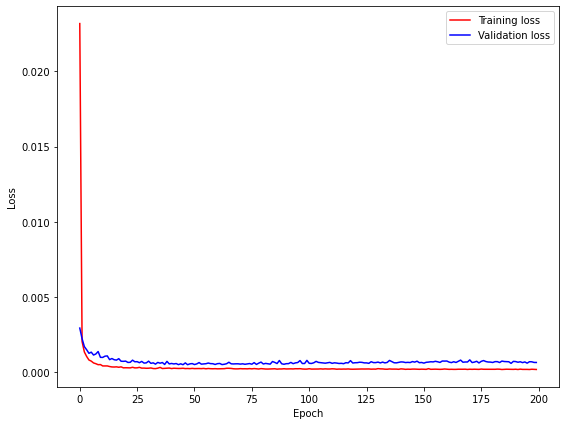

In [15]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='red')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='blue')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
preds = cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

y_pred = pd.DataFrame([x[0] for x in y_pred_unscaled])
y_actual = pd.DataFrame([y[0] for y in y_test_unscaled])

difference = y_actual- y_pred

97/97 [==============================] - 1s 2ms/step


In [17]:
dataframe['Date'] = [datetime.datetime.utcfromtimestamp(x) for x in dataframe['Date']]
dataframe['date'] = [x.date() for x in dataframe['Date']]
days = pd.DataFrame(dataframe['Date'].values[-len(preds):])
test_frame = pd.concat([days, y_actual, y_pred], axis = 1)
test_frame.columns = ['Date', 'Actual', 'Predicted']

In [18]:
print(f'Predicted Minimum Temperature: {y_pred_unscaled.min()}')
print(f'Actual Minimum Temperature: {y_test_unscaled.min()}')

Predicted Minimum Temperature: -6.659142017364502
Actual Minimum Temperature: -9.5


In [19]:
e_mse = mse(y_actual,y_pred)
print(f'The Mean Squared Error is: {e_mse}')

e_mae = mae(y_actual,y_pred)
print(f'The Mean Absolute Error is: {e_mae}')

r2 = r2_score(y_actual,y_pred)
print(f'The R\u00b2 is: {r2}')

print(f'Running time(sec) is: {running_secs}')


The Mean Squared Error is: 2.19202728575679
The Mean Absolute Error is: 1.0027332762896382
The R² is: 0.9875003790812387
Running time(sec) is: 214


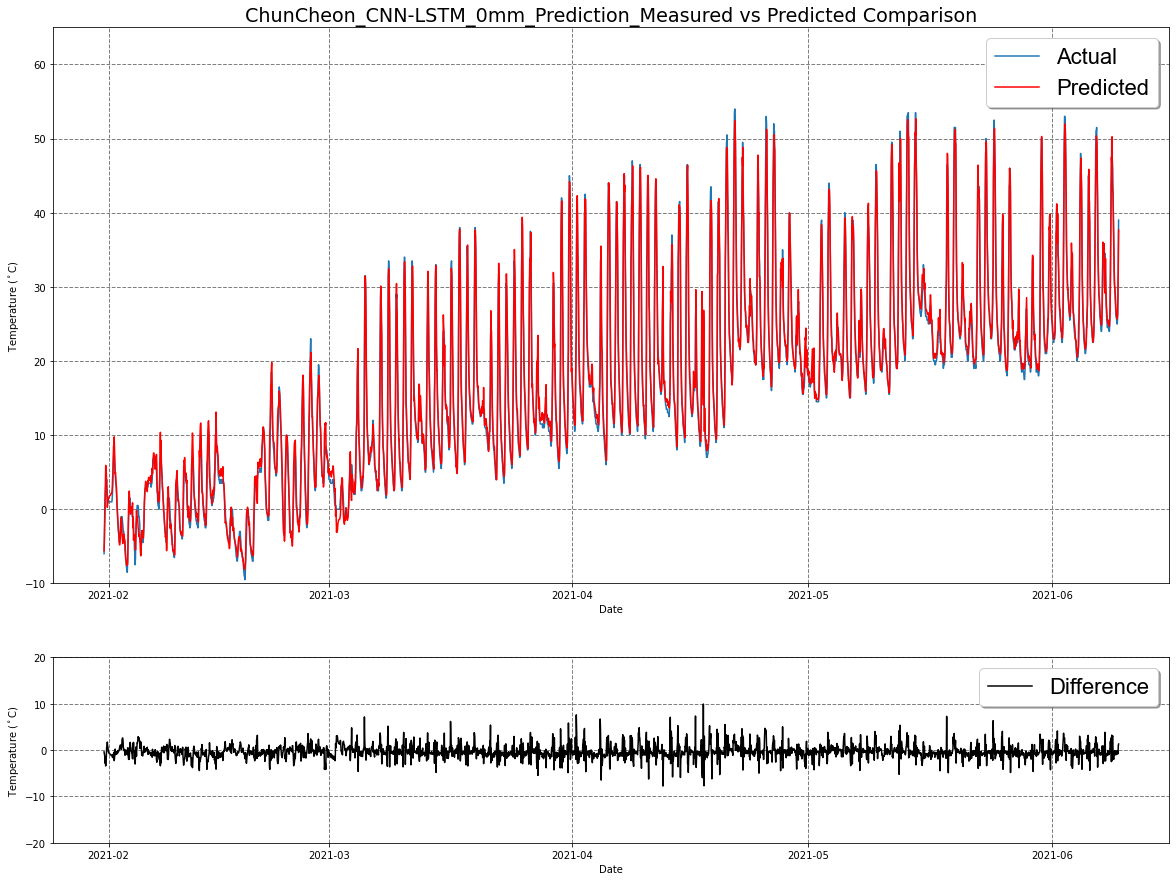

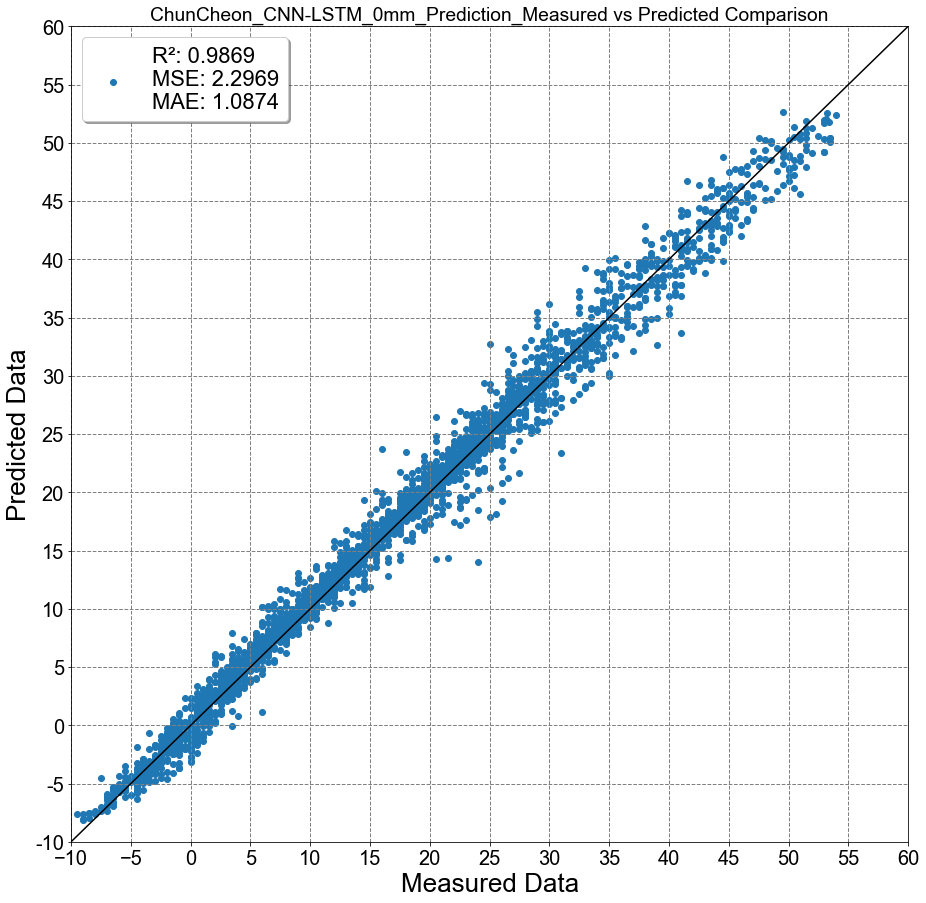

In [22]:
# Figure 1
from matplotlib.dates import DateFormatter, MonthLocator

fig, pred_ax = plt.subplots(2,figsize=(20,15),gridspec_kw={'height_ratios': [3,1]})

# set font
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

# plot data 
pred_ax[0].plot(test_frame['Date'], test_frame['Actual'], label='Actual', )
pred_ax[0].plot(test_frame['Date'], test_frame['Predicted'], color='red', label='Predicted')
pred_ax[1].plot(test_frame['Date'], test_frame['Actual']- test_frame['Predicted'], color='k', label='Difference')

# set legend position
pred_ax[0].legend(shadow=True, loc='upper right', fontsize = 22)
pred_ax[1].legend(shadow=True, loc='upper right', fontsize = 22)



for ax in pred_ax.flat:
    ax.set(xlabel='Date', ylabel='Temperature ($^\circ$C)')


    
pred_ax[0].set_title(f'{location}_{model}_{depth}_Prediction_Measured vs Predicted Comparison')

# set axis-limits
pred_ax[0].set_ylim(bottom = -10, top=65) 
pred_ax[1].set_ylim(bottom = -20, top=20) 

# set grid
pred_ax[0].grid(color='gray', linestyle='--', linewidth=1)
pred_ax[1].grid(color='gray', linestyle='--', linewidth=1)

months = MonthLocator()
monthsFmt = DateFormatter("%b '%y")
pred_ax[0].xaxis.set_major_locator(months)
pred_ax[1].xaxis.set_major_locator(months)

# plt.savefig(f'{date_processed}_{location}_{model}_{depth}_{filename}Prediction_Measured vs Predicted Comparison.png', dpi=300)
plt.show()

################################################################################################################################


# Figure 2
fig, pred_ax = plt.subplots(figsize=(15,15))

# set font
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

# plot data 
plt.scatter( test_frame['Actual'],  test_frame['Predicted'], label=f'R\u00b2: {round(r2, 4)}\nMSE: {round(e_mse, 4)}\nMAE: {round(e_mae,4)}')
x = np.linspace(-15, 75, 1000)
plt.plot(x, x + 0, "black")
pred_ax.legend(shadow=True, loc='upper left', fontsize = 22)

plt.title(f'{location}_{model}_{depth}_Prediction_Measured vs Predicted Comparison')
plt.xlabel('Measured Data', fontsize = 26)
plt.ylabel('Predicted Data', fontsize = 26)

plt.xlim(left = -10, right = 30) 
plt.ylim(bottom = -10, top=30)

plt.grid(color='gray', linestyle='--', linewidth=1)

plt.xticks(np.arange(-10,61,5), fontsize = 20)
plt.yticks(np.arange(-10,61,5), fontsize = 20)

pred_ax.set_yticklabels(['{:,}'.format(int(x)) for x in pred_ax.get_yticks().tolist()])
# plt.savefig(f'{date_processed}_{location}_{model}_{depth}_{filename}_Prediction_Measured vs Predicted Comparison_2.png', dpi=300)
plt.show()

In [23]:
# ## Saving the result file to the folder of the model
# try:
#     os.chdir(os.path.join(dest,f'{location}_{model}'))
#     print('Directory present')
# except FileNotFoundError:
#     print('Creating a new directory......')
#     os.chdir(os.path.join(dest))
#     os.mkdir(f'{location}_{model}')
#     os.chdir(os.path.join(dest,f'{location}_{model}'))
#     print('New Directory Created')


# results_filename = f'{date_processed}_{location}_{model}_{depth}_{filename}_Validation_Results.xlsx'

# writer = pd.ExcelWriter(results_filename, engine='openpyxl') 
# wb  = writer.book
# test_frame.to_excel(writer, index=False)
# wb.save(results_filename)

# saved_model_name = f'{date_processed}_{location}_{filename}_{depth}_{r2}.hdf5'

# save_directory = os.path.join(model_folder,saved_model_name)
# cnnlstm.save_weights(save_directory)

# print('Model Saved')
# print(f'Model Name: {save_directory}')